# Part 3: Covid Precautionary Measures Sentiment

### Context: 
When considering how a person responds to the pandemic, whether it be wearing masks in public or getting the COVID vaccine, we were interested in learning about how one's political affiliation may play a role in their willingness to adhere to state mandates. After looking at several subreddits (specific communities on Reddit) on COVID-related posts, there seems to be a difference in sentiment towards the pandemic for Republicans and Democrats. In order to get a comprehensive understanding of the differences in response, we analyzed data throughout the course of the entire pandemic in addition to recent statistics.  


### Method:
Looking at state data using several APIs, we web scraped the information into dataframes containing relevant information. The CDC provides a extensive number of datasets that can be retrieved from the Open Data Source API. For number of cases specifically, we used the Covid Act Now API to obtain the time series for two of the largest states in the United States with polarized political values, California ($\color{blue}{\text{Dem}}$) and Texas ($\color{red}{\text{Rep}}$).

To evaluate the relationship between vaccination rate and political affiliation, we referred to the CDC's data on vaccine hesitancy for counties in America along with the majority political party identification of each state from Wikipedia's *Political party strength in U.S. states* page.

In [12]:
import requests
import pandas as pd
import numpy as np
import lxml.html as lx
import seaborn as sns
sns.set_style("darkgrid")


import matplotlib.pyplot as plt

In [5]:
key = "455a847e8a92464f98ece023015975ff"

In [6]:
import json
allstates = requests.get("https://api.covidactnow.org/v2/states.timeseries.json?apiKey=455a847e8a92464f98ece023015975ff")
data = json.loads(allstates.text)
ca_df = pd.json_normalize(data[4]) # normalize CA data from the list of all json
tx_df = pd.json_normalize(data[45]) # normalize TX data
ca_ts = pd.json_normalize(ca_df["actualsTimeseries"][0]) # select times series json from CA
tx_ts = pd.json_normalize(tx_df["actualsTimeseries"][0]) # select times series json from TX

Because population size is a major influence on number of total cases, we normalized the data using the states' populations.

In [7]:
def pop_normalize(case, pop):
    return case/pop*100000 # return incidence rate

In [8]:
ca_ts["Cases Per 100K"] = [pop_normalize(case, ca_df.population) for case in ca_ts["cases"]]
ca_ts["Cases Per 100K"] = [ca_ts["Cases Per 100K"][i][0] for i in range(len(ca_ts["Cases Per 100K"]))] # select numeric
                                                                                                        # incidence rate
tx_ts["Cases Per 100K"] = [pop_normalize(case, tx_df.population) for case in tx_ts["cases"]]
tx_ts["Cases Per 100K"] = [tx_ts["Cases Per 100K"][i][0] for i in range(len(tx_ts["Cases Per 100K"]))]
ca_ts["date"] = pd.to_datetime(ca_ts["date"])
tx_ts["date"] = pd.to_datetime(tx_ts["date"])
ca_ts["state"] = "CA"
tx_ts["state"] = "TX"

Though there were many NaN values scattered throughout the dataset, we can still refer to the relevant columns (cases & deaths) without dropping these rows.

In [9]:
joint_df = pd.concat([ca_ts, tx_ts], ignore_index=True) # stack both dataframes 
joint_df

,cases,deaths,positiveTests,negativeTests,contactTracers,newCases,newDeaths,vaccinesAdministeredDemographics,vaccinationsInitiatedDemographics,date,...,icuBeds.capacity,icuBeds.currentUsageTotal,icuBeds.currentUsageCovid,vaccinesDistributed,vaccinationsInitiated,vaccinationsCompleted,vaccinationsAdditionalDose,vaccinesAdministered,Cases Per 100K,state
0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,None,None,2020-01-25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002531,CA
1,2.0,0.0,NaN,NaN,NaN,1.0,0.0,None,None,2020-01-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005062,CA
2,2.0,0.0,NaN,NaN,NaN,0.0,0.0,None,None,2020-01-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005062,CA
3,2.0,0.0,NaN,NaN,NaN,0.0,0.0,None,None,2020-01-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005062,CA
4,2.0,0.0,NaN,NaN,NaN,0.0,0.0,None,None,2020-01-29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005062,CA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,6560264.0,86117.0,6691227.0,41414333.0,NaN,5132.0,126.0,None,None,2022-03-09,...,6258.0,5597.0,560.0,59201895.0,20710121.0,17486305.0,6303638.0,44661265.0,22624.813504,TX
1536,6566067.0,86266.0,6691264.0,41415902.0,NaN,5803.0,149.0,None,None,2022-03-10,...,6298.0,5564.0,526.0,59247995.0,20723606.0,17494744.0,6312461.0,44693438.0,22644.826691,TX
1537,6574225.0,86366.0,NaN,NaN,NaN,8158.0,100.0,None,None,2022-03-11,...,6694.0,5612.0,494.0,59363595.0,20715479.0,17486035.0,6316692.0,44726431.0,22672.961722,TX
1538,6577325.0,86455.0,NaN,NaN,NaN,3100.0,89.0,None,None,2022-03-12,...,6694.0,5618.0,490.0,59363595.0,20727169.0,17493588.0,6325014.0,44755582.0,22683.652895,TX


Using a line plot to examine the incidence rate over the course of the pandemic (changes in growth rates at each point in time will be the slope of the curves). Line plots are optimal for displaying time series data, clearly showing changes in growth of case rates each quarter starting from January 2020.

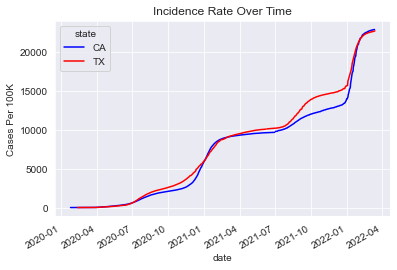

In [48]:
sns.lineplot(x=joint_df.date, y=joint_df["Cases Per 100K"], hue=joint_df["state"],
             palette=["blue", 'red']).set_title("Incidence Rate Over Time").get_figure().autofmt_xdate()

In [17]:
from scipy.stats import ttest_ind
stat, p = ttest_ind(ca_ts["Cases Per 100K"].dropna(), tx_ts["Cases Per 100K"].dropna()) # drop rows with NaN for both states
print(stat, p) # return t-stat of case rates

-2.3070487905818493 0.02118490789324234


We perform a Student's t test to see if there is a true different in mean incidence rates for the two states. The negative t-statistic, -2.3070487905818493, indicates that California had a lower mean incidence rate over the course of the pandemic. We conclude that the two states did not have the same mean incidence rate because our p-value of 0.02118490789324234 is significant.

In [2]:
import requests
def get_df(url): # function for obtaining DFs from CDC API json links
    response = requests.get(url)
    html = lx.fromstring(response.text)
    paragraphs = html.xpath("//p")
    content = [paragraph.text_content() for paragraph in paragraphs]
    df = pd.read_json(content[0])
    return df

The CDC provided information on county hesitancy rates based on Household Pulse Survey responses. A response of "1" corresponds to "definitely getting the vaccine" and a response of "5" means "definitely not getting the vaccine."

In [18]:
hesitancy = pd.read_json("https://data.cdc.gov/api/id/q9mh-h2tw.json")
hesitancy

,fips_code,county_name,state,estimated_hesitant,estimated_hesitant_or_unsure,estimated_strongly_hesitant,social_vulnerability_index,svi_category,ability_to_handle_a_covid,cvac_category,...,percent_non_hispanic_asian,percent_non_hispanic_black,percent_non_hispanic_native,percent_non_hispanic_white,geographical_point,state_code,county_boundary,state_boundary,:@computed_region_hjsp_umg2,:@computed_region_skr5_azej
0,1123,"Tallapoosa County, Alabama",ALABAMA,0.1806,0.2400,0.1383,0.89,Very High Vulnerability,0.64,High Concern,...,0.0036,0.2697,0.0000,0.6887,"{'type': 'Point', 'coordinates': [-86.844516, ...",AL,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...","{'type': 'MultiPolygon', 'coordinates': [[[[-8...",29,94
1,1121,"Talladega County, Alabama",ALABAMA,0.1783,0.2350,0.1368,0.87,Very High Vulnerability,0.84,Very High Concern,...,0.0061,0.3237,0.0003,0.6263,"{'type': 'Point', 'coordinates': [-86.844516, ...",AL,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...","{'type': 'MultiPolygon', 'coordinates': [[[[-8...",29,94
2,1131,"Wilcox County, Alabama",ALABAMA,0.1735,0.2357,0.1337,0.93,Very High Vulnerability,0.94,Very High Concern,...,0.0003,0.6938,0.0000,0.2684,"{'type': 'Point', 'coordinates': [-86.844516, ...",AL,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...","{'type': 'MultiPolygon', 'coordinates': [[[[-8...",29,94
3,1129,"Washington County, Alabama",ALABAMA,0.1735,0.2357,0.1337,0.73,High Vulnerability,0.82,Very High Concern,...,0.0025,0.2354,0.0000,0.6495,"{'type': 'Point', 'coordinates': [-86.844516, ...",AL,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...","{'type': 'MultiPolygon', 'coordinates': [[[[-8...",29,94
4,1133,"Winston County, Alabama",ALABAMA,0.1805,0.2313,0.1379,0.70,High Vulnerability,0.80,High Concern,...,0.0016,0.0073,0.0005,0.9370,"{'type': 'Point', 'coordinates': [-86.844516, ...",AL,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...","{'type': 'MultiPolygon', 'coordinates': [[[[-8...",29,94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,20003,"Anderson County, Kansas",KANSAS,0.1560,0.2068,0.0963,0.23,Low Vulnerability,0.63,High Concern,...,0.0001,0.0050,0.0000,0.9484,"{'type': 'Point', 'coordinates': [-98.38018, 3...",KS,"{'type': 'MultiPolygon', 'coordinates': [[[[-9...","{'type': 'MultiPolygon', 'coordinates': [[[[-1...",17,1287
996,19029,"Cass County, Iowa",IOWA,0.1323,0.1905,0.0795,0.20,Very Low Vulnerability,0.09,Very Low Concern,...,0.0028,0.0020,0.0014,0.9529,"{'type': 'Point', 'coordinates': [-93.500061, ...",IA,"{'type': 'MultiPolygon', 'coordinates': [[[[-9...","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",16,299
997,19171,"Tama County, Iowa",IOWA,0.1293,0.1877,0.0781,0.33,Low Vulnerability,0.10,Very Low Concern,...,0.0046,0.0092,0.0000,0.8075,"{'type': 'Point', 'coordinates': [-93.500061, ...",IA,"{'type': 'MultiPolygon', 'coordinates': [[[[-9...","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",16,299
998,19085,"Harrison County, Iowa",IOWA,0.1323,0.1905,0.0795,0.06,Very Low Vulnerability,0.02,Very Low Concern,...,0.0049,0.0019,0.0004,0.9620,"{'type': 'Point', 'coordinates': [-93.500061, ...",IA,"{'type': 'MultiPolygon', 'coordinates': [[[[-9...","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",16,299


The COVID Data Tracker from the CDC also establishes the number of doses delivered for each state.

In [19]:
#https://covid.cdc.gov/covid-data-tracker/#vaccinations_vacc-total-admin-rate-total
vaccination = pd.read_csv("C:\\Users\\chris\\Documents\\STA 141B\\covid19_vaccinations_in_the_united_states.csv")
vaccination.columns = vaccination.iloc[3,:] # column names are in third row
vaccination = vaccination.iloc[4:,:] # remove the blank first rows
vaccination['State/Territory/Federal Entity'] = [state.lower() for state in vaccination['State/Territory/Federal Entity']]
vaccination                                                 # lower state names for merging dfs

3,State/Territory/Federal Entity,Total Doses Delivered,Doses Delivered per 100K,18+ Doses Delivered per 100K,Total Doses Administered by State where Administered,Doses Administered per 100k by State where Administered,18+ Doses Administered by State where Administered,18+ Doses Administered per 100K by State where Administered,People with at least One Dose by State of Residence,Percent of Total Pop with at least One Dose by State of Residence,...,Percent People Primary Moderna Booster J&J,Percent People Primary Moderna Booster Other,Percent People Primary J&J Booster Pfizer,Percent People Primary J&J Booster Moderna,Percent People Primary J&J Booster J&J,Percent People Primary J&J Booster Other,Percent People Primary Other Booster Pfizer,Percent People Primary Other Booster Moderna,Percent People Primary Other Booster J&J,Percent People Primary Other Booster Uknown
4,united states,689797945,207765,267095,552526931,166419,500683736,193868,253395029,76.3,...,0.1,0,34.1,41.4,24.4,0,51.4,43,0.3,5.2
5,alaska,1443865,197372,261777,1093935,149538,983376,178289,500935,68.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,alabama,9252240,188699,242530,6094167,124290,5695106,149287,3033599,61.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,arkansas,5858220,194122,252766,4085165,135369,3730583,160964,1982981,65.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,american samoa,92810,195835,296186,87449,184523,63896,203913,42783,90.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,vermont,1697650,272064,332883,1345762,215671,1207850,236841,577604,92.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,washington,16837495,221113,282896,13839196,181739,12491888,209883,6069678,79.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,wisconsin,11082845,190347,243267,9858587,169321,8998372,197513,4136395,71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,west virginia,3849485,214797,268710,2634424,146998,2465598,172109,1150072,64.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Wikipedia includes several tables highlighting different political strengths for states in the U.S. We specifically chose to look at poltical party identification majorities in each state.

In [20]:
import urllib.request as urlrq
import certifi
import ssl

resp = urlrq.urlopen("https://en.wikipedia.org/wiki/Political_party_strength_in_U.S._states", 
                     context=ssl.create_default_context(cafile=certifi.where()))

In [21]:
ssl._create_default_https_context = ssl._create_unverified_context # bypass certification requirement
lst= pd.read_html("https://en.wikipedia.org/wiki/Political_party_strength_in_U.S._states") # read in tables

The party identification column includes number detailing the split between parties, which must be cleaned up for clear party majority assignment.

In [22]:
def clean_party(states): # remove irrelavant details of party identification
    if "Republican" in states:
        return "Republican"
    elif "Democratic" in states:
        return "Democratic"
    else:
        return "Even"

In [23]:
df = pd.DataFrame(lst[5]) # make df out of table of interest (6th)
df = df.rename(columns={"State": "state", 'Party registration or identification (% as of 2020': "Party identification"})
df["Party identification"] = [clean_party(state) for state in df["Party identification"]]
df

,state,2020 presidentialelection,Governor,State Senate,State House,SeniorU.S. Senator,JuniorU.S. Senator,U.S. House of Representatives,Party identification
0,Alabama,Republican,Republican,Republican 27–8,Republican 77–28,Republican,Republican,Republican 6–1,Republican
1,Alaska,Republican,Republican,Republican 13–7,Coalition 23–17[b],Republican,Republican,Republican,Republican
2,Arizona,Democratic,Republican,Republican 16–14,Republican 31–29,Democratic,Democratic,Democratic 5–4,Republican
3,Arkansas,Republican,Republican,Republican 28–7,Republican 77–23,Republican,Republican,Republican 4,Republican
4,California,Democratic,Democratic,Democratic 31–9,Democratic 59–19–1,Democratic,Democratic,Democratic 42–11,Democratic
5,Colorado,Democratic,Democratic,Democratic 20–15,Democratic 41–24,Democratic,Democratic,Democratic 4–3,Democratic
6,Connecticut,Democratic,Democratic,Democratic 24–12,Democratic 97–54,Democratic,Democratic,Democratic 5,Democratic
7,Delaware,Democratic,Democratic,Democratic 14–7,Democratic 26–15,Democratic,Democratic,Democratic,Democratic
8,Florida,Republican,Republican,Republican 24–16,Republican 78–42,Republican,Republican,Republican 16–10–1[d],Republican
9,Georgia,Democratic,Republican,Republican 34–22,Republican 103–77,Democratic,Democratic,Republican 8-6,Democratic


In [24]:
df['state'] = [state.lower() for state in df['state']] # lower for df merging
hesitancy['state'] = [state.lower() for state in hesitancy['state']]

In [25]:
corr_df = hesitancy.merge(df, on='state') # combine the dfs on state name
corr_df

,fips_code,county_name,state,estimated_hesitant,estimated_hesitant_or_unsure,estimated_strongly_hesitant,social_vulnerability_index,svi_category,ability_to_handle_a_covid,cvac_category,...,:@computed_region_hjsp_umg2,:@computed_region_skr5_azej,2020 presidentialelection,Governor,State Senate,State House,SeniorU.S. Senator,JuniorU.S. Senator,U.S. House of Representatives,Party identification
0,1123,"Tallapoosa County, Alabama",alabama,0.1806,0.2400,0.1383,0.89,Very High Vulnerability,0.64,High Concern,...,29,94,Republican,Republican,Republican 27–8,Republican 77–28,Republican,Republican,Republican 6–1,Republican
1,1121,"Talladega County, Alabama",alabama,0.1783,0.2350,0.1368,0.87,Very High Vulnerability,0.84,Very High Concern,...,29,94,Republican,Republican,Republican 27–8,Republican 77–28,Republican,Republican,Republican 6–1,Republican
2,1131,"Wilcox County, Alabama",alabama,0.1735,0.2357,0.1337,0.93,Very High Vulnerability,0.94,Very High Concern,...,29,94,Republican,Republican,Republican 27–8,Republican 77–28,Republican,Republican,Republican 6–1,Republican
3,1129,"Washington County, Alabama",alabama,0.1735,0.2357,0.1337,0.73,High Vulnerability,0.82,Very High Concern,...,29,94,Republican,Republican,Republican 27–8,Republican 77–28,Republican,Republican,Republican 6–1,Republican
4,1133,"Winston County, Alabama",alabama,0.1805,0.2313,0.1379,0.70,High Vulnerability,0.80,High Concern,...,29,94,Republican,Republican,Republican 27–8,Republican 77–28,Republican,Republican,Republican 6–1,Republican
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,19029,"Cass County, Iowa",iowa,0.1323,0.1905,0.0795,0.20,Very Low Vulnerability,0.09,Very Low Concern,...,16,299,Republican,Republican,Republican 32–18,Republican 59–41,Republican,Republican,Republican 3–1,Democratic
995,19171,"Tama County, Iowa",iowa,0.1293,0.1877,0.0781,0.33,Low Vulnerability,0.10,Very Low Concern,...,16,299,Republican,Republican,Republican 32–18,Republican 59–41,Republican,Republican,Republican 3–1,Democratic
996,19085,"Harrison County, Iowa",iowa,0.1323,0.1905,0.0795,0.06,Very Low Vulnerability,0.02,Very Low Concern,...,16,299,Republican,Republican,Republican 32–18,Republican 59–41,Republican,Republican,Republican 3–1,Democratic
997,19173,"Taylor County, Iowa",iowa,0.1362,0.1966,0.0841,0.28,Low Vulnerability,0.14,Very Low Concern,...,16,299,Republican,Republican,Republican 32–18,Republican 59–41,Republican,Republican,Republican 3–1,Democratic


We take the average over counties of each state using panda's groupby.

In [26]:
vaccination = vaccination.rename(columns={'State/Territory/Federal Entity':'state'})
corr_df = corr_df.merge(vaccination, on = 'state')
final = corr_df.groupby(['state', 'Party identification', 'Doses Delivered per 100K']).estimated_hesitant.mean()
final       # groupby states and return the estimated mean hesitancy for each state state

state          Party identification  Doses Delivered per 100K
alabama        Republican            188699                      0.173507
alaska         Republican            197372                      0.217386
arizona        Republican            193468                      0.159240
arkansas       Republican            194122                      0.212123
california     Democratic            217234                      0.072274
colorado       Democratic            205989                      0.078220
connecticut    Democratic            232655                      0.056987
delaware       Democratic            227936                      0.059433
florida        Republican            212403                      0.145212
georgia        Democratic            194463                      0.161815
hawaii         Democratic            234299                      0.059500
idaho          Republican            179758                      0.192023
illinois       Democratic            206425       

In [27]:
final_df = pd.DataFrame()
final_df['state'] = final.index.get_level_values(0) # get values from indices of groupby object
final_df['Party identification'] = final.index.get_level_values(1)
final_df['Doses Delivered per 100K'] = final.index.get_level_values(2)
final_df['Mean Estimated Hesitancy'] = final.values
final_df

,state,Party identification,Doses Delivered per 100K,Mean Estimated Hesitancy
0,alabama,Republican,188699,0.173507
1,alaska,Republican,197372,0.217386
2,arizona,Republican,193468,0.159240
3,arkansas,Republican,194122,0.212123
4,california,Democratic,217234,0.072274
5,colorado,Democratic,205989,0.078220
6,connecticut,Democratic,232655,0.056987
7,delaware,Democratic,227936,0.059433
8,florida,Republican,212403,0.145212
9,georgia,Democratic,194463,0.161815


Text(0.5, 1.0, 'Vaccine Rate vs. Hesitancy by Party')

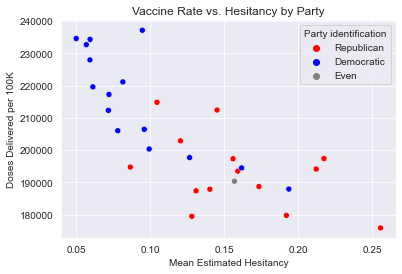

In [44]:
final_df['Doses Delivered per 100K'] = [int(x) for x in final_df['Doses Delivered per 100K']] # change values into numbers
sns.scatterplot(x = final_df['Mean Estimated Hesitancy'], y = final_df['Doses Delivered per 100K'], 
                hue=final_df['Party identification'], 
                palette=['red', 'blue', 'gray']).set_title("Vaccine Rate vs. Hesitancy by Party")

In [30]:
from scipy.stats import pearsonr
corr, _ = pearsonr(final_df["Mean Estimated Hesitancy"], final_df["Doses Delivered per 100K"]) #return pearson correlation
corr

-0.7792915361789933

As expected, states with higher hesitancy also had lower doses delivered. There is a strong negative correlation between hesitancy and number of vaccine doses delivered overall.

In [31]:
final_df["Binary Party"] = [1 if row == 'Republican' else 0 for row in final_df["Party identification"]] 
                            # Create binary labels to perform correlation measure with political party

In [32]:
corr, _ = pearsonr(final_df["Mean Estimated Hesitancy"], final_df["Binary Party"])
corr

0.5909235276025876

There is a strong positive correlation between political affiliation and mean estimated hesitancy. Republicans generally had higher hesitancy towards getting the COVID vaccine.

We now consider the incidence rates as of March 5 for all states.

In [33]:
# Generated march 5
last7_df = pd.read_csv("C:\\Users\\chris\\Documents\\STA 141B\\united_states_covid19_cases_deaths_and_testing_by_state.csv")
last7_df.columns = last7_df.iloc[1,:] # column names are in 2nd row 
last7_df = last7_df.iloc[1:,:] # remove blank row

In [34]:
last7_df = last7_df.rename(columns={'State/Territory': 'state'})
last7_df['state'] = [state.lower() for state in last7_df['state']]
last7_df

1,state,Level of Community Transmission,Total Cases,Confirmed Cases,Probable Cases,Cases in Last 7 Days,Case Rate per 100000,Total Deaths,Confirmed Deaths,Probable Deaths,...,% Positive Last 30 Days,% Positive Last 7 Days,# Tests per 100K,Total # Tests,# Tests per 100K Last 7 Days,Total # Tests Last 7 Days,# Tests per 100K Last 30 Days,Total # Tests Last 30 Days,New Cases,New Deaths
1,state/territory,Level of Community Transmission,Total Cases,Confirmed Cases,Probable Cases,Cases in Last 7 Days,Case Rate per 100000,Total Deaths,Confirmed Deaths,Probable Deaths,...,% Positive Last 30 Days,% Positive Last 7 Days,# Tests per 100K,Total # Tests,# Tests per 100K Last 7 Days,Total # Tests Last 7 Days,# Tests per 100K Last 30 Days,Total # Tests Last 30 Days,New Cases,New Deaths
2,alabama,high,1286317,926826,359491,7290,26234,18568,14284,4284,...,15-19.9%,5-7.9%,147925.971,7280224,951.63,46835,5108.96,251439,3366,88
3,alaska,high,232933,0,0,2085,31841,1158,NaN,NaN,...,15-19.9%,5-7.9%,563264.5748,4118354,531.35,3885,14041.01,102662,701,0
4,american samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,arizona,high,1980769,1754308,226461,5517,27213,27708,23633,4075,...,15-19.9%,5-7.9%,190941.0905,14170504,1199.8,89042,7709.51,572154,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,virginia,high,1647027,1174940,472087,8563,19296,19005,15758,3247,...,10-14.9%,5-7.9%,162736.8195,13980009,1125.78,96711,6487.92,557349,1235,49
60,washington,high,1430235,0,0,14356,18782,12025,NaN,NaN,...,NaN,NaN,150201.0889,11555889,1949.05,149952,7588.85,583857,1529,71
61,west virginia,high,492276,390520,101756,3917,27468,6440,NaN,NaN,...,15-19.9%,8-9.9%,275252.1169,4912664,2438.22,43517,13883.51,247791,578,13
62,wisconsin,substantial,1574581,1383739,190842,4121,27043,13489,12089,1400,...,8-9.9%,3-4.9%,267552.0153,15605386,1681.45,98073,9770.04,569853,542,39


In [39]:
cases_final = final_df.merge(last7_df, on='state')
cases_final["Case Rate per 100000"] = cases_final['Case Rate per 100000'].astype(int) # change case rate datatype into int 
cases_final = cases_final.rename(columns={"Case Rate per 100000": "Cases Per 100K"})

Text(0.5, 1.0, 'Incidence Rates vs. Hesitancy by Party')

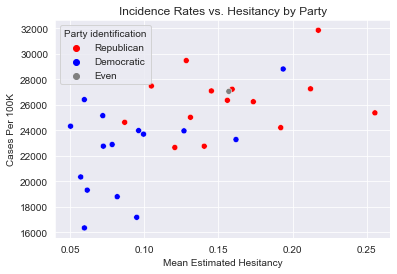

In [45]:
sns.scatterplot(x = cases_final['Mean Estimated Hesitancy'], y = cases_final['Cases Per 100K'], 
                hue=cases_final['Party identification'],
                palette=['red', 'blue', 'gray']).set_title("Incidence Rates vs. Hesitancy by Party")

In [41]:
corr, _ = pearsonr(cases_final["Mean Estimated Hesitancy"], cases_final["Cases Per 100K"])
corr

0.581533647025002

There is a positive correlation between vaccine hesitancy and incidence rates for states in the US. 

In [49]:
corr, _ = pearsonr(cases_final["Binary Party"], cases_final["Cases Per 100K"])
corr

0.5043996947529066

When considering more states, there is still a positive correlation between incidence rates and political party.